<a href="https://colab.research.google.com/github/Kerriea-star/TensorFlow-Decision-Forests/blob/main/Learning_Decision_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Build, train and Evaluate a model with Decision Forests**

*Introduction*

In [4]:
pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    

Installing TF-DF

In [5]:
pip install wurlitzer

Wurlitzer is needed to display the detailed training logs in Colabs (when using verbose=2 in the model)

In [6]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [7]:
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setInfameHeight(0, true, {maxHeight: " + str(size) +"})"))

In [8]:
# check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.5.0


**Training a Random Forest Model**

In this section we train, evaluate, analyze and export a multi-class classification Random Forest trained on the Palmer's Penguins dataset

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [9]:
# Download the Dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# load the dataset into a Pandas DataFrame
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


The dataset contains a mix of numerical (e.g bill_depth_mm), categorical(e.g. island) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra is_[present feature.

Labels are a bit different:Keras metrics expect integers. The label (species) is stored as string, so let's convert it into an integer.

In [10]:
# Encode the categorical labels as integers
# Details:
# This is necessary if your classification label is represented as a
# string since Keras expects inter classification labels
# When using 'pd_dataframe_to_tf_dataset' (see below) this steo can be skipped.

# Name of the column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Next split the dataset into training and testing

In [11]:
# Split the dataset into a training and testing dataset
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe into two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)
))

239 examples in training, 105 examples for testing.


And finally, convert the pandas dataframe (pd.DataFrame) into tensorflow datasets (tf.data.Datasets)

In [12]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

Recall that pd_dataframe_to_tf_dataset converts string labels to integers if necessary.

If you want to create the tf.data.Dataset yourself, there are a couple of things to remember


*   The learning algorithms work with a one-epoch dataset and without shuffling
*   The batch size does not impact the training algorithm, but a small value might slow down reading the dataset



**Train the model**

In [13]:
%set_cell_height 300

# Specify the model
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model
model_1.fit(train_ds)

<IPython.core.display.Javascript object>

Use 2 thread(s) for training
Use /tmp/tmpcji3rv1w as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'island': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'bill_length_mm': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'bill_depth_mm': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'flipper_length_mm': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'body_mass_g': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'sex': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'year': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>}
Label: Tensor("data_7:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'island': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'bill_length_mm': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'bill_depth_mm': SemanticTensor(semantic=<Semantic.NUMERIC

[INFO 23-08-11 13:29:46.4501 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-08-11 13:29:46.4501 UTC kernel.cc:774] Collect training examples
[INFO 23-08-11 13:29:46.4502 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-08-11 13:29:46.4508 UTC kernel.cc:393] Number of batches: 1
[INFO 23-08-11 13:29:46.4508 UTC kernel.cc:394] Number of examples: 239
[INFO 23-08-11 13:29:46.4509 UTC kernel.cc:794] Training dataset:
Number of records: 239
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	1: "bill_depth_mm" NUMERICAL num-nas:1 (0.41841%) mean:17.1588 min:13

Model trained in 0:00:00.337771
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


Remarks

*   No input features are specified. Therefore, all the columns will be used as input features except for the label. The feature used by the model are shown in the training logs and the model_summary()
*   DFs consume natively numerical, categorical, categorical-set features and
missing values. Numerical features do not need to be normalized. Categorical string values do not need to be encoded in a dictionary.
*   No training hyper-parameters are specified. Therefore hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations.
*   Calling compile on the model before the fit is optional. Compile can be used to provide extra evaluation metrics.
*   Training algorithms do not need validation sets. If a validation set is provided, it will only be used to show metrics
*   Tweak the verbose argument to RandomForestModel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs





**Evaluate the model**

In [14]:
# Let's evaluate the model on the test dataset
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 741ms/step - loss: 0.0000e+00 - accuracy: 0.9905

loss: 0.0000
accuracy: 0.9905


Remark: The test accuracy is close to the Out-of-bag accuracy shown in the training logs.



In [17]:
# Prepare the model for TensorFlow Serving
# Export the model to the SavedModel format later re-use e.g. TensorFlow Serving
model_1.save("/tmp/my_save_model")

In [15]:
# Prepare this model for TensorFlow Serving
# Export the model to the SavedModel format later re-use e.g. TensorFlow Serving
import os
import tempfile
import requests

MODEL_DIR = "ML/models/decision_forests"
version = "1"
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model_1.save(export_path, save_format="tf")
print("\nexport_path = {}".format(export_path))
!dir {export_path}


export_path = ML/models/decision_forests/1
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [16]:
!zip -r decision_forests.zip ML/models/decision_forests

  adding: ML/models/decision_forests/ (stored 0%)
  adding: ML/models/decision_forests/1/ (stored 0%)
  adding: ML/models/decision_forests/1/assets/ (stored 0%)
  adding: ML/models/decision_forests/1/assets/54b1583a39474b67random_forest_header.pb (deflated 91%)
  adding: ML/models/decision_forests/1/assets/54b1583a39474b67header.pb (deflated 29%)
  adding: ML/models/decision_forests/1/assets/54b1583a39474b67data_spec.pb (deflated 16%)
  adding: ML/models/decision_forests/1/assets/54b1583a39474b67done (stored 0%)
  adding: ML/models/decision_forests/1/assets/54b1583a39474b67nodes-00000-of-00001 (deflated 83%)
  adding: ML/models/decision_forests/1/fingerprint.pb (stored 0%)
  adding: ML/models/decision_forests/1/keras_metadata.pb (deflated 79%)
  adding: ML/models/decision_forests/1/saved_model.pb (deflated 86%)
  adding: ML/models/decision_forests/1/variables/ (stored 0%)
  adding: ML/models/decision_forests/1/variables/variables.index (deflated 46%)
  adding: ML/models/decision_forest

**Plot the model**

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interesting to plant than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest Model.

In [18]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node in the left contains the first condition (bill_depth_mm >= 16.90), number of examples (239) and label distribution (the red-blue-green bar).

Examples that evaluates true to bill_depth_mm >= 16.90 are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more pure they become i.e. the label distribution is biased toward a susbset of classes.

**Model Structure and feature importance**

The overall structure of the model is shown with .summary(). You will see:

*   **Type**: The learning algorithm used to train the model (RandomForest in our case).
*   **Task**: The problem solved by the model (Classification in our case).
*   **Input Features**: The input features of the model
*   **Variable Importance**: Different measures of the importance of each feature for the model
*   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a cheap and efficient alternative to cross-validation
*   **Number of {trees, nodes} and other metrics**: Statistics about the structure of the decision forests

**Remark**: The summary's content depends on the learning algorithm(e.g Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g. the mean-decrease-in-accuracy variable importance can be disabled in the hyper-parameters).

In [19]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.    "bill_length_mm"  0.429654 ################
    2. "flipper_length_mm"  0.417333 ##############
    3.     "bill_depth_mm"  0.340084 ########
    4.            "island"  0.318389 ######
    5.       "body_mass_g"  0.278494 ##
    6.               "sex"  0.248377 
    7.              "year"  0.247411 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 136.000000 ################
    2.    "bill_length_mm" 76.000000 ########
    3.     "

In [20]:
# The information in summary are available programmatically using the model inspector
# The input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #1),
 "bill_length_mm" (1; #2),
 "body_mass_g" (1; #3),
 "flipper_length_mm" (1; #4),
 "island" (4; #5),
 "sex" (4; #6),
 "year" (1; #7)]

In [21]:
# The feature importances
model_1.make_inspector().variable_importances()

{'INV_MEAN_MIN_DEPTH': [("bill_length_mm" (1; #2), 0.4296539213334384),
  ("flipper_length_mm" (1; #4), 0.4173334532508822),
  ("bill_depth_mm" (1; #1), 0.34008371574584495),
  ("island" (4; #5), 0.3183887913244586),
  ("body_mass_g" (1; #3), 0.27849369102744825),
  ("sex" (4; #6), 0.24837668896688425),
  ("year" (1; #7), 0.2474114269357245)],
 'SUM_SCORE': [("bill_length_mm" (1; #2), 25898.65507181734),
  ("flipper_length_mm" (1; #4), 20924.106670012698),
  ("bill_depth_mm" (1; #1), 13108.451144745573),
  ("island" (4; #5), 9471.205674536526),
  ("body_mass_g" (1; #3), 2603.0789140146226),
  ("sex" (4; #6), 229.01513655483723),
  ("year" (1; #7), 24.762972071766853)],
 'NUM_AS_ROOT': [("flipper_length_mm" (1; #4), 136.0),
  ("bill_length_mm" (1; #2), 76.0),
  ("bill_depth_mm" (1; #1), 74.0),
  ("island" (4; #5), 9.0),
  ("body_mass_g" (1; #3), 5.0)],
 'NUM_NODES': [("bill_length_mm" (1; #2), 623.0),
  ("bill_depth_mm" (1; #1), 348.0),
  ("flipper_length_mm" (1; #4), 332.0),
  ("island

The content of the summary and the inspector depends on the learning algorithm(tfdf.keras.RandomForestModel in class) and its hyper-parameters (e.g comput_oob_variable_importances=True will triger the computation of Out-of-bag variable importances for the Random Forest learner)

**Model Self Evaluation**

During training TFDF models can self evaluate even if no validation dataset is provided to the fit() method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note**: While this evaluation is computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation

The model self evaluation is available with the inspector's evaluation()

In [22]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=239, accuracy=0.9665271966527197, loss=0.08273266184155412, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

**Plotting the training logs**

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality

The logs are available in multiple ways:

1.   Displayed in during training if fit() is wrapped in with sys_pipes().
2.   At the end of the model summary i.e. model.summary()
3.   Programmatically, using the model inspector i.e model.make_inspector().train_logs().
4.   Using TensorBoard

Let's try the options 2 and 3



In [23]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=88, accuracy=0.9431818181818182, loss=2.04793474890969, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=239, accuracy=0.9539748953974896, loss=0.3754553880277538, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=239, accuracy=0.9707112970711297, loss=0.23363683435083932, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=239, accuracy=0.9707112970711297, loss=0.0796907191714233, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=239, accuracy=0.9623430962343096, loss=0.08233576088707317, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=239, accuracy=0.9707112970711297, loss=0.08103505969359286, rmse=Non

Let's plot it

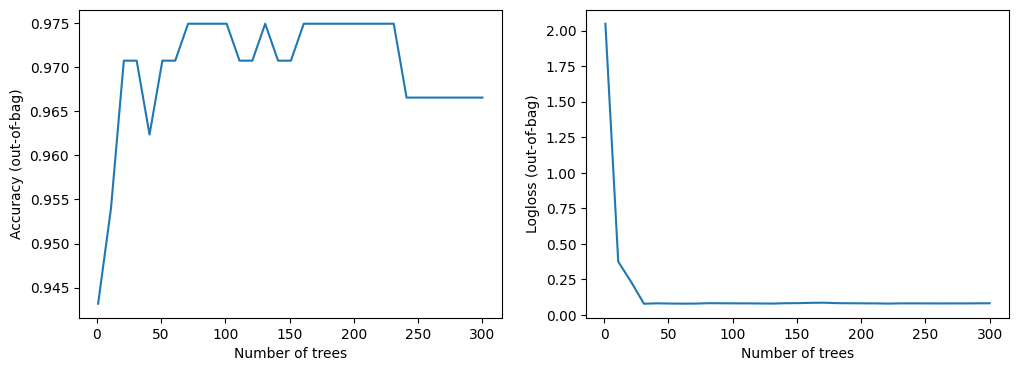

In [24]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard

In [25]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [31]:
# export the meta-data to tensorboard
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")


In [32]:
# docs_infra: no_execute
# Start a tensorboard instance
%tensorboard --logdir "/tmp/tensorboard_logs"

<IPython.core.display.Javascript object>

**Re-trian the model with a different learning algorithm**

The learning algorithm is defined by the model class. For example, tfdf.keras.RandomForestModel() trains a Random Forest, while tfdf.keras.GradientBoostedTreesModel() trains a Gradient Boosted Decision Trees.

The learning algorithms are listed by calling tfdf.keras.get_all_models() or in the learner list.

In [33]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the API refrence and buitin help

In [34]:
# help works anywhere
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Method resolution order:
 |      RandomForestModel
 |      tensorflow_decision_forests.keras.wrappers.RandomForestModel
 |      tensorflow_decision_forests.keras.core.CoreModel
 |      tensorflow_decision_forests.keras.core_inference.InferenceCoreModel
 |      keras.src.engine.training.Model
 |      keras.src.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      keras.src.utils.version_utils.LayerVersionSelector
 |      keras.src.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  -------------------------------------------------------------